In [23]:
import sys, os, glob
import numpy, scipy

path = "../work/run-scf-spc"
assert os.path.exists(path)

# find all the out.log files
out_logs = glob.glob(os.path.join(path, "**", "out.log"), recursive=True)

def get_info_from_out_log(out_log):
    d = {}
    kmesh = out_log.split("/")[4]
    kmesh = [int(x) for x in kmesh.split("-")]
    d["kmesh"] = numpy.prod(kmesh)
    d["method"] = "-".join(out_log.split("/")[5].split("-")[:-1])
    d["ncpu"] = int(out_log.split("/")[5].split("-")[-1])
    d["cell"] = out_log.split("/")[3]
    d["natm"] = 2 if d["cell"] == "diamond-prim" else 8

    with open(out_log, "r") as f:
        table = []
        for line in f:
            if "CPU time" in line:
                key_word = line.split()[3]
                wall_time = line.split()[8]
                d["t_" + key_word] = float(wall_time)

            if "###" in line:
                table.append(line)

        if len(table) == 2: # spc
            keys = table[0][3:].split(",")
            values = table[1][3:].split(",")
            for key, value in zip(keys, values):
                d[key.strip()] = float(value.strip())

    return d

data = []
# read the out.log files
for out_log in out_logs:
    d = get_info_from_out_log(out_log)

    if d["cell"] == "diamond-prim":
        data.append(d)

print(data)


[{'kmesh': 32, 'method': 'fftisdf-ks', 'ncpu': 1, 'cell': 'diamond-prim', 'natm': 2, 't_build': 309.44, 't_vj': 366.72, 't_vk': 26.36, 'ke_cutoff': 100.0, 'rcut_epsilon': 1e-05, 'ke_epsilon': 0.05, 'isdf_thresh': 5e-05, 'e_tot': -356.61565}, {'kmesh': 32, 'method': 'fftdf', 'ncpu': 32, 'cell': 'diamond-prim', 'natm': 2, 't_build': 0.01, 't_vj': 17.74, 't_vk': 9185.53}, {'kmesh': 32, 'method': 'fftdf', 'ncpu': 1, 'cell': 'diamond-prim', 'natm': 2, 't_build': 0.01, 't_vj': 184.26}, {'kmesh': 32, 'method': 'gdf', 'ncpu': 1, 'cell': 'diamond-prim', 'natm': 2, 't_build': 6751.65, 't_vj': 81.74, 't_vk': 623.5, 'e_tot': -356.613393}, {'kmesh': 32, 'method': 'gdf', 'ncpu': 32, 'cell': 'diamond-prim', 'natm': 2, 't_build': 291.61, 't_vj': 52.35, 't_vk': 50.12, 'e_tot': -356.613393}, {'kmesh': 64, 'method': 'fftisdf-ks', 'ncpu': 1, 'cell': 'diamond-prim', 'natm': 2, 't_build': 1343.15, 't_vj': 1974.99, 't_vk': 210.72}, {'kmesh': 64, 'method': 'fftdf', 'ncpu': 32, 'cell': 'diamond-prim', 'natm': 

[ 1  2  4  8 16 32 64] [6.40e-05 1.13e-04 1.71e-04 6.33e-04      nan      nan      nan]


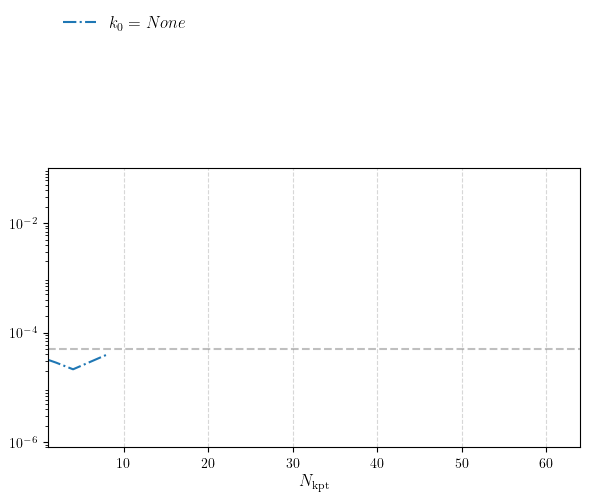

In [30]:
# plot all the data with kpts
import matplotlib.pyplot as plt
# use latex
plt.rcParams["text.usetex"] = True
# use latex font
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Computer Modern Roman"

# fig, ax = plt.subplots()

method = ["fftdf", "gdf", "fftisdf-ks"]

# plot all the error
kmesh = []
kmesh = numpy.array(kmesh)
kmesh = numpy.unique(kmesh)

fig, axs = plt.subplots(1, 1, figsize=(6, 6), sharex=True)

d0 = [d for d in data if d["method"] == "fftdf" and d["ncpu"] == 1]
d1 = [d for d in data if d["method"] == "fftisdf-ks" and d["ncpu"] == 1]

i = 0
ax = axs
# ax.text(0.05, 0.80, f"$c_0 = {c0:.1f}$", transform=ax.transAxes, fontsize=14)
ax.axhline(5e-5, color="grey", linestyle="--", alpha=0.5)
ax.grid(True, which="major", alpha=0.5, linestyle="--", axis="x")

x0 = [d["kmesh"] for d in d0]
y0 = [d.get("e_tot", numpy.nan) for d in d0]
x0 = numpy.array(x0)
y0 = numpy.array(y0)
m = numpy.argsort(x0)
x0 = x0[m]
y0 = y0[m]

x1 = [d["kmesh"] for d in d1]
y1 = [d.get("e_tot", numpy.nan) for d in d1]
x1 = numpy.array(x1)
y1 = numpy.array(y1)
m = numpy.argsort(x1)
x1 = x1[m]
y1 = y1[m]

xx = x0
yy = abs(y0 - y1) + 1e-6
natm = d0[0]["natm"]
ax.semilogy(xx, yy / natm / xx, label=f"$k_0={k0}$", linestyle="-.")

ax.set_xlim(x0[0], x0[-1])
ax.set_ylim(8e-7, 0.1)
ax.set_yticks([1e-6, 1e-4, 1e-2])
# ax.set_yticklabels(["1e-6", "1e-5", "1e-4", "1e-3", "1e-2"])

# put it to the top
# no box
ax.legend(
    loc="upper left",
    bbox_to_anchor=(0, 1.6),
    ncol=3, fontsize=12,
    frameon=False, columnspacing=4.0
)
fig.tight_layout()

ax.set_xlabel(r"$N_{\mathrm{kpt}}$", fontsize=12)
# for ax in axs:
    # ax.set_ylabel("Energy error", fontsize=12)

plt.show()
        

In [ ]:
dd = []
for d in data:
    if d["method"] == "fftisdf-ks" and d["ncpu"] == 1:
        dd.append(d)

for d1 in sorted(dd, key=lambda x: x["kmesh"]):
    kmesh = d1["kmesh"]
    t_build = d1["t_build"]
    t_vj = d1["t_vj"]
    t_vk = d1["t_vk"]

    e_ref = None
    for d2 in data:
        if d2["method"] == "fftdf" and d2["ncpu"] == 1 and d2["kmesh"] == kmesh:
            e_ref = d2["e_tot"]
            break

    assert e_ref is not None
    natm = d1["natm"]
    # print(natm)
    err = abs(e_ref - d1["e_tot"]) / natm
    print(f"{kmesh:4d} {t_build:6.2f} {t_vj:6.2f} {t_vk:6.2f} {err:6.2e}")
    # assert err < 5e-5

dd = sorted(dd, key=lambda x: x["kmesh"])

2
   1   1.86   0.16   0.02 3.15e-05
2
   2   3.51   0.54   0.04 5.60e-05
2
   4   9.11   2.59   0.12 8.50e-05
2
   8  26.87  14.39   0.76 3.16e-04


KeyError: 'e_tot'

In [260]:
df = []
for d in data:
    if d["method"] == "fftdf" and d["ncpu"] == 1:
        df.append(d)

df = sorted(df, key=lambda x: x["kmesh"])

dg = []
for d in data:
    if d["method"] == "gdf" and d["ncpu"] == 1:
        dg.append(d)

dg = sorted(dg, key=lambda x: x["kmesh"])



[1. 2. 3. 4. 5. 6. 7.] [1.5, 2.02, 3.05, 5.88, 12.82, 25.9, 44.71]


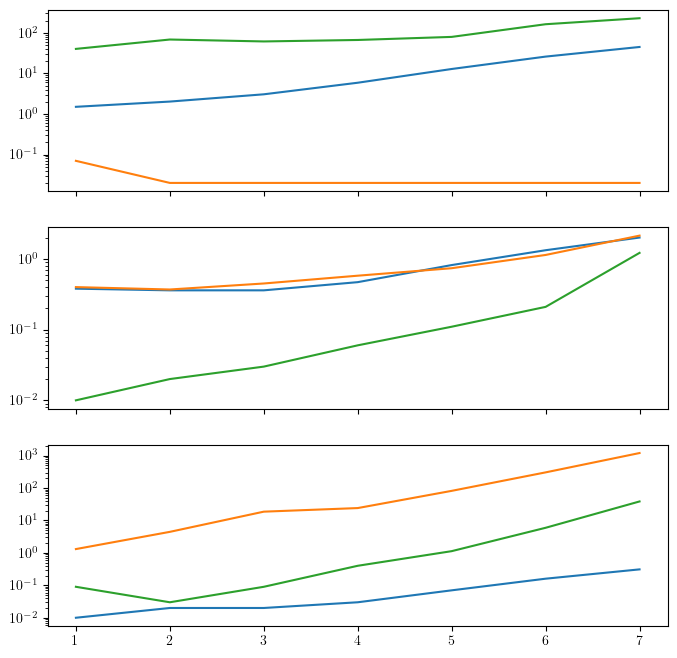

In [261]:
fig, axs = plt.subplots(3, 1, figsize=(8, 8), sharex=True)

# plot the timing
ax = axs[0]
natm = dd[0]["natm"]
x = [d["kmesh"] * natm for d in dd]
x = numpy.log2(x)
y = [d["t_build"] for d in dd]
print(x, y)
ax.semilogy(x, y, label="fftisdf")

x = [d["kmesh"] * natm for d in df]
x = numpy.log2(x)
y = [d["t_build"] + 1e-2 for d in df]
ax.semilogy(x, y, label="fftdf")

x = [d["kmesh"] * natm for d in dg]
x = numpy.log2(x)
y = [d["t_build"] for d in dg]
ax.semilogy(x, y, label="gdf")

ax = axs[1]
x = [d["kmesh"] * natm for d in dd]
x = numpy.log2(x)
y = [d["t_vj"] + 1e-2 for d in dd]
ax.semilogy(x, y, label="fftisdf")

x = [d["kmesh"] * natm for d in df]
x = numpy.log2(x)
y = [d["t_vj"] + 1e-2 for d in df]
ax.semilogy(x, y, label="fftdf")

x = [d["kmesh"] * natm for d in dg]
x = numpy.log2(x)
y = [d["t_vj"] + 1e-2 for d in dg]
ax.semilogy(x, y, label="gdf")

ax = axs[2]
x = [d["kmesh"] * natm for d in dd]
x = numpy.log2(x)
y = [d["t_vk"] + 1e-2 for d in dd]
ax.semilogy(x, y, label="fftisdf")

x = [d["kmesh"] * natm for d in df]
x = numpy.log2(x)
y = [d["t_vk"] + 1e-2 for d in df]
ax.semilogy(x, y, label="fftdf")

x = [d["kmesh"] * natm for d in dg]
x = numpy.log2(x)
y = [d["t_vk"] + 1e-2 for d in dg]
ax.semilogy(x, y, label="gdf")

# ax.legend()